# Predictions

In [2]:
import os

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

import networkx as nx

import scipy
from scipy.linalg import fractional_matrix_power
from scipy.linalg import logm, expm

import pyriemann
import collections

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
%load_ext autoreload
%autoreload 2
from dan.utils import fhd_map, fhd_numeric_map, uper_vectorization

In [4]:
!pwd

/home/warrior/Documents/connplexity_lab/research/code


In [5]:
demo_path = '../hasda/simple_data/demographics/demo.csv'
diagonals_path = '../hasda/simple_data/output/network_diagonals.csv'
netwoks_path = '../hasda/simple_data/output/networks_info.csv'

In [6]:
demo = pd.read_csv(demo_path)
diagonals = pd.read_csv(diagonals_path)
networks = pd.read_csv(netwoks_path)
print('demo',demo.shape)
#print(demo.columns)
print('diagonals',diagonals.shape)
#print(diagonals.columns)
print('networks', networks.shape)
#print(networks.columns)

demo (57, 8)
diagonals (57, 19)
networks (19, 4)


In [22]:
demo.head()

,subject,sex,age,fhd,audit,nur,pur,tlfb_ddd,fhd_3,fh
0,n0002,male,27,0.38,4,11,5,1.78,3_fhp,2
1,n0037,male,44,0.20,8,9,4,5.56,2_fha,1
2,n0050,female,21,0.00,8,7,7,4.00,1_fhn,0
3,n0073,male,37,0.20,5,7,8,1.72,2_fha,1
4,n0101,female,48,0.17,7,7,5,3.82,2_fha,1


### IDENTIFICATION PLOTS

In [7]:
networks = pd.read_csv(netwoks_path)
#networks['r2'] = r_summary.iloc[-1].values
networks['network_name'] = [x[14:] if len(x)>13 else x for x in networks['network_name']]
#networks.rename(columns={'idf_rate':'id_rate'}, inplace=True)
networks.sort_values('id_rate', ascending=False, inplace=True)
print(networks.id_rate.min(), networks.id_rate.max())
networks.head(3)

0.2456140350877192 1.0


,network_id,network_name,regions,id_rate
18,brain,Whole_brain,232,1.0
10,n11,ContA_Temp_1,20,1.0
17,n18,aHIP-rh,32,1.0


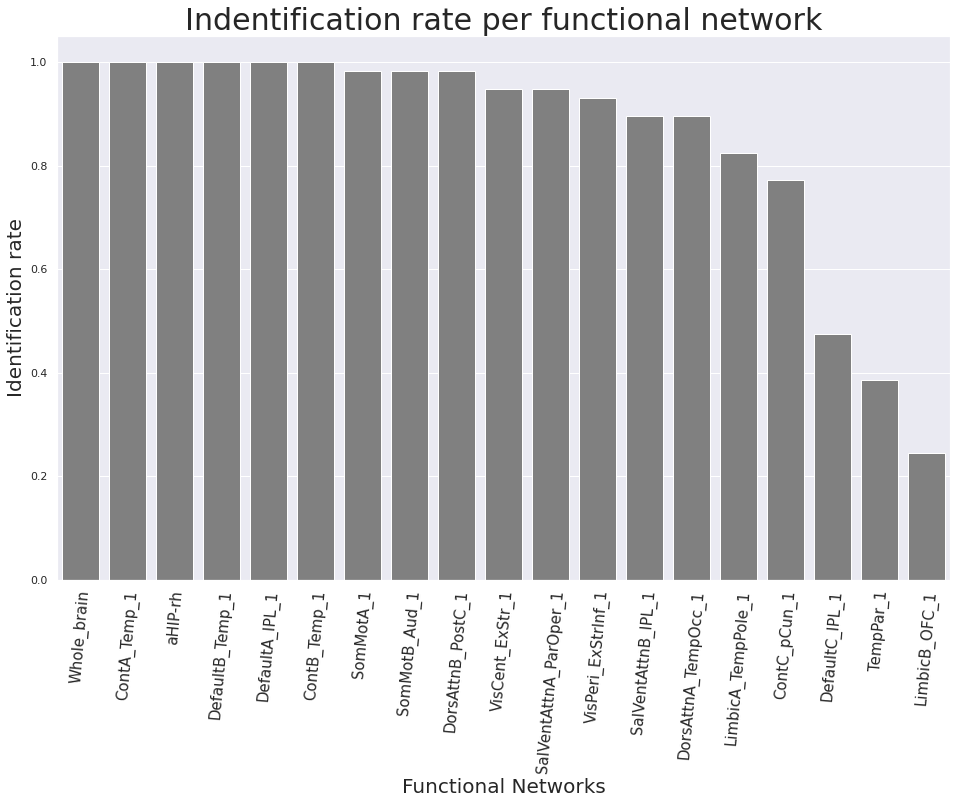

In [8]:
plt.figure(figsize=(16,10))
plt.title('Indentification rate per functional network', fontsize=30)
color = ['gray']*len(networks)
sns.barplot(data=networks, x='network_name', y='id_rate', palette=color)
plt.ylabel('Identification rate', fontsize=20)
plt.xlabel('Functional Networks', fontsize=20)
plt.ylim(0,1.05)
plt.xticks(fontsize=15, rotation = 85)
#axes.set_title('Multilinear model',fontsize=20)
plt.show()

In [11]:
print(diagonals.shape)
diagonals_sorted = diagonals.sort_values('brain', ascending=False)
diagonals_sorted.reset_index(inplace=True)
diagonals_sorted.rename(columns={'index':'subject'}, inplace=True)

diagonals_sorted.head(3)
diagonals_sorted.brain.min(), diagonals_sorted.brain.max()

(57, 19)


(0.7080345877204531, 0.8832597036038741)

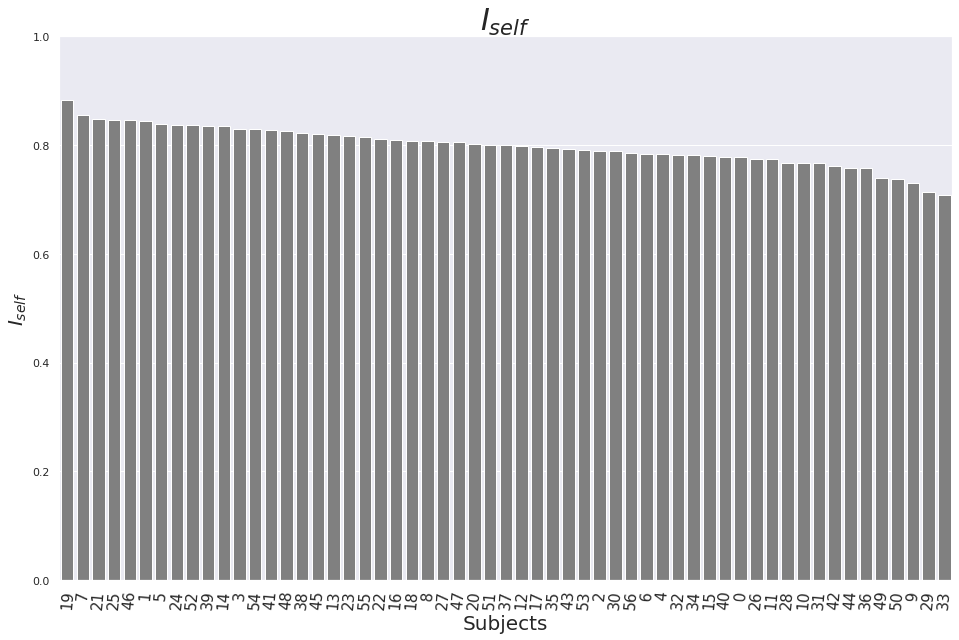

In [12]:
plt.figure(figsize=(16,10))
plt.title('$I_{self}$', fontsize=30)
color = ['gray']*len(networks)
sns.barplot(data=diagonals_sorted, x=diagonals_sorted.index, y='brain', palette=color)
plt.ylabel('$I_{self}$', fontsize=20)
plt.xlabel('Subjects', fontsize=20)
plt.ylim(0, 1.0)
plt.xticks(ticks=diagonals_sorted.index, labels=diagonals_sorted.subject.values, fontsize=15, rotation = 85)

plt.show()

### REGRESSION

In [13]:
demo = pd.read_csv(demo_path)

demo['fhd_3'] = demo['fhd'].map(lambda x: fhd_map(x))
demo['fh'] = demo['fhd'].map(lambda x: fhd_numeric_map(x))

demo.columns = [s.lower() for s in demo.columns]
demo['audit'] = demo['audit'].replace('#NULL!',0)
demo['audit'] = demo['audit'].astype(int)

demo_fhd = demo[['subject','sex', 'age', 'audit', 'nur', 'pur', 'tlfb_ddd', 'fhd']]
demo_cfhd = demo[['subject','sex', 'age', 'audit', 'nur', 'pur', 'tlfb_ddd', 'fhd_3']]
demo_cfhd_beta = demo[['subject','sex', 'age', 'fhd_3', 'audit', 'nur', 'pur', 'tlfb_ddd']]
demo_num_fhd = demo[['subject','sex', 'age', 'audit', 'nur', 'pur', 'tlfb_ddd', 'fh']]
demo_num_fhd_beta = demo[['subject','sex', 'age', 'fh', 'audit', 'nur', 'pur', 'tlfb_ddd']]

demo.head(3)

,subject,sex,age,fhd,audit,nur,pur,tlfb_ddd,fhd_3,fh
0,n0002,male,27,0.38,4,11,5,1.78,3_fhp,2
1,n0037,male,44,0.20,8,9,4,5.56,2_fha,1
2,n0050,female,21,0.00,8,7,7,4.00,1_fhn,0


### FHD

In [14]:
network_r = {}
network_p = {}
for i in diagonals.columns:
    #print(i)
    X_raw, y_raw = demo_fhd.iloc[:,1:], diagonals[i]
    X_formula = pd.concat([X_raw, y_raw], axis=1)
    #print(X_formula.columns.values)
    variables = []
    r_values = []
    for j in X_formula.columns[:-1]:
        if j in ['sex','cat_fh']:
            j = 'C('+j+')'
        variables.append(j)
        formula = i+' ~ '+' + '.join(variables)
        #print(' ',formula)
        est = smf.ols(formula=formula, data=X_formula).fit()
        #print(' ',est.rsquared)
        r_values.append(est.rsquared)
        #print(' ',est.pvalues.round(3))
        
    #print('')
    network_r[i] = r_values
    network_p[i] = est.pvalues
print(formula)

prediction = est.predict(X_formula)

brain ~ C(sex) + age + audit + nur + pur + tlfb_ddd + fhd


In [15]:
r_summary = pd.DataFrame(network_r, index=X_formula.columns.values[:-1])
r_summary

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15,n16,n17,n18,brain
sex,0.055528,0.005005,0.007441,0.021292,0.000737,0.024218,0.000206,0.014280,0.018240,0.115574,0.000015,0.016484,0.005495,0.001198,0.021731,0.011881,0.009724,0.075996,0.002235
age,0.056112,0.047701,0.018351,0.022320,0.031702,0.024723,0.001077,0.015803,0.018557,0.184114,0.054035,0.016561,0.007120,0.002222,0.022481,0.059825,0.027857,0.092993,0.032324
audit,0.073901,0.052501,0.020329,0.028412,0.031775,0.034752,0.004587,0.017720,0.026806,0.202737,0.075449,0.039741,0.008579,0.105130,0.032953,0.207262,0.092788,0.121751,0.054976
nur,0.115466,0.058772,0.030461,0.034433,0.059385,0.034864,0.033052,0.044682,0.047701,0.237802,0.077670,0.088250,0.008693,0.117584,0.035277,0.207263,0.097589,0.127582,0.157077
pur,0.157935,0.060047,0.045322,0.038480,0.065038,0.062288,0.060876,0.103039,0.050168,0.245318,0.078112,0.093247,0.037451,0.121153,0.044804,0.226545,0.114902,0.127968,0.157078
tlfb_ddd,0.168499,0.066259,0.048982,0.042988,0.071417,0.072896,0.084659,0.107401,0.052065,0.264699,0.093933,0.149403,0.037522,0.123437,0.049290,0.228436,0.129836,0.137718,0.159306
fhd,0.207667,0.072664,0.073656,0.073804,0.138710,0.072931,0.119325,0.124926,0.063632,0.275358,0.155127,0.149478,0.077093,0.167868,0.050824,0.229624,0.130213,0.154462,0.173445


In [16]:
p_summary = pd.DataFrame(network_p).round(4)
p_summary

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15,n16,n17,n18,brain
Intercept,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0852,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
C(sex)[T.male],0.1894,0.4353,0.5446,0.4220,0.7612,0.2370,0.8793,0.4815,0.2678,0.0515,0.7130,0.2664,0.4112,0.4440,0.4355,0.4745,0.3349,0.0266,0.8695
age,0.3426,0.0738,0.1869,0.6765,0.1352,0.8460,0.5573,0.6403,0.8636,0.0599,0.3505,0.8576,0.4439,0.7610,0.8422,0.3448,0.1651,0.0957,0.0730
audit,0.2351,0.6313,0.8116,0.5568,0.5989,0.6936,0.9283,0.7726,0.6872,0.2926,0.1825,0.3065,0.7147,0.0557,0.3494,0.0101,0.1419,0.1942,0.2057
nur,0.9932,0.8977,0.8468,0.2922,0.2580,0.5518,0.2342,0.7238,0.4151,0.4343,0.8747,0.2062,0.3503,0.4166,0.9500,0.5525,0.3253,0.9425,0.0762
pur,0.3742,0.9351,0.6614,0.9893,0.5316,0.1723,0.0767,0.0507,0.7326,0.3558,0.8593,0.2443,0.4008,0.5774,0.6157,0.2810,0.5664,0.7506,0.9772
tlfb_ddd,0.2558,0.4915,0.4903,0.4430,0.8986,0.4640,0.1553,0.4797,0.9015,0.3649,0.6258,0.0839,0.6921,0.9827,0.6893,0.7860,0.3952,0.3412,0.8899
fhd,0.1261,0.5634,0.2588,0.2077,0.0561,0.9661,0.1712,0.3267,0.4403,0.4000,0.0655,0.9476,0.1536,0.1122,0.7796,0.7846,0.8847,0.3294,0.3644


In [17]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  brain   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.469
Date:                Thu, 29 Sep 2022   Prob (F-statistic):              0.200
Time:                        18:46:28   Log-Likelihood:                 114.95
No. Observations:                  57   AIC:                            -213.9
Df Residuals:                      49   BIC:                            -197.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8113      0.023     34.

In [33]:
networks = pd.read_csv(netwoks_path)
networks['r2'] = r_summary.iloc[-1].values
networks['network_name'] = [x[14:] if len(x)>13 else x for x in networks['network_name']]
networks.sort_values('id_rate', ascending=False, inplace=True)
networks

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.000000,0.263819
10,n11,ContA_Temp_1,20,1.000000,0.217768
17,n18,aHIP-rh,32,1.000000,0.218815
14,n15,DefaultB_Temp_1,26,1.000000,0.095222
13,n14,DefaultA_IPL_1,16,1.000000,0.271582
11,n12,ContB_Temp_1,10,1.000000,0.136214
2,n3,SomMotA_1,16,0.979592,0.081707
3,n4,SomMotB_Aud_1,16,0.979592,0.097167
5,n6,DorsAttnB_PostC_1,10,0.979592,0.094666
0,n1,VisCent_ExStr_1,12,0.959184,0.250068


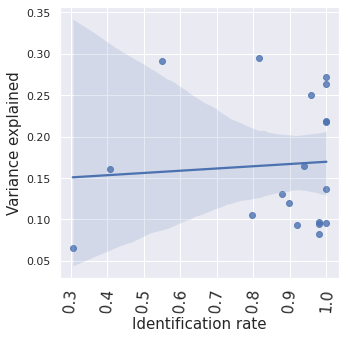

In [34]:
plt.figure(figsize=(5,5))
plt.title('', fontsize=20)
sns.regplot(x=networks.id_rate, y=networks.r2)
plt.ylabel('Variance explained', fontsize=15)
plt.xlabel('Identification rate', fontsize=15)
#plt.ylim(0,1.2)
plt.xticks(fontsize=15, rotation = 85)
#axes.set_title('Multilinear model',fontsize=20)
plt.show()

In [35]:
net = 'brain'

In [ ]:
 diagonals[i]

In [36]:
errors = diagonals[net] - prediction
network_info = networks[networks['network_id']==net]
network_info

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.0,0.263819


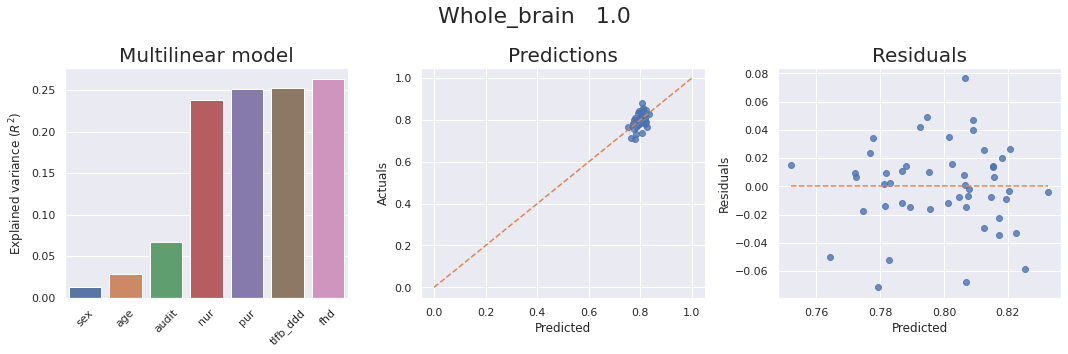

In [37]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'{network_info.network_name.values[0]}   {network_info.id_rate.values[0]}', fontsize=22)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.regplot(x=prediction.values, y=errors, fit_reg=False)
axes.set_ylabel('Residuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

### CAT FHD

In [17]:
network_r = {}
network_p = {}
for i in diagonals.columns:
    #print(i)
    X_raw, y_raw = demo_cfhd.iloc[:,1:], diagonals[i] # CAT FHD
    X_formula = pd.concat([X_raw, y_raw], axis=1)
    #print(X_formula.columns.values)
    variables = []
    r_values = []
    for j in X_formula.columns[:-1]:
        if j in ['sex','fhd_3']:
            j = 'C('+j+')'
        variables.append(j)
        formula = i+' ~ '+' + '.join(variables)
        #print(' ',formula)
        est = smf.ols(formula=formula, data=X_formula).fit()
        #print(' ',est.rsquared)
        r_values.append(est.rsquared)
        #print(' ',est.pvalues.round(3))
        
    #print('')
    network_r[i] = r_values
    network_p[i] = est.pvalues
print(formula)

prediction = est.predict(X_formula)

brain ~ C(sex) + age + audit + nur + pur + tlfb_ddd + C(fhd_3)


In [18]:
r_summary = pd.DataFrame(network_r, index=X_formula.columns.values[:-1])
p_summary = pd.DataFrame(network_p).round(4)

In [19]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  brain   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     1.638
Date:                Thu, 29 Sep 2022   Prob (F-statistic):              0.139
Time:                        23:51:17   Log-Likelihood:                 116.41
No. Observations:                  57   AIC:                            -214.8
Df Residuals:                      48   BIC:                            -196.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8077      0.02

In [20]:
networks = pd.read_csv(netwoks_path)
networks['r2'] = r_summary.iloc[-1].values
networks['network_name'] = [x[14:] if len(x)>13 else x for x in networks['network_name']]
networks.sort_values('id_rate', ascending=False, inplace=True)
networks

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.000000,0.214471
10,n11,ContA_Temp_1,20,1.000000,0.165633
17,n18,aHIP-rh,32,1.000000,0.159250
14,n15,DefaultB_Temp_1,26,1.000000,0.058029
13,n14,DefaultA_IPL_1,16,1.000000,0.155712
11,n12,ContB_Temp_1,10,1.000000,0.163122
2,n3,SomMotA_1,16,0.982456,0.071210
3,n4,SomMotB_Aud_1,16,0.982456,0.173366
5,n6,DorsAttnB_PostC_1,10,0.982456,0.144748
0,n1,VisCent_ExStr_1,12,0.947368,0.194169


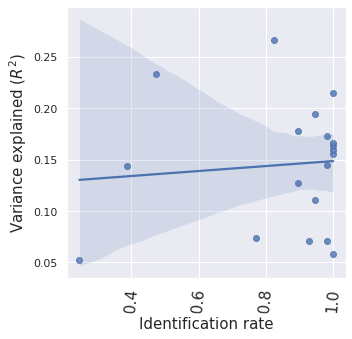

In [21]:
plt.figure(figsize=(5,5))
plt.title('', fontsize=20)
sns.regplot(x=networks.id_rate, y=networks.r2)
plt.ylabel('Variance explained ($R^2$)', fontsize=15)
plt.xlabel('Identification rate', fontsize=15)
#plt.ylim(0,1.2)
plt.xticks(fontsize=15, rotation = 85)
#axes.set_title('Multilinear model',fontsize=20)
plt.show()

In [24]:
net = 'brain'

In [36]:
errors = diagonals[net] - prediction
network_info = networks[networks['network_id']==net]
network_info

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.0,0.214471


In [89]:
p_center, d_center = np.mean(prediction), np.mean(diagonals[net])
p_std, d_std = np.std(prediction), np.std(diagonals[net])
n_std = 6

In [90]:
def type_map(x, news):
    
    if x in news:
        y = 'new'
    else:
        y = 'old'
    
    return y

In [91]:
news = ['0602','0538','0547','0582','0584','0587','0589','0596','0611']

prediction_df = pd.DataFrame({'subject':[s.replace('n','') for s in demo.subject],
                             'pred':prediction,
                             'actual':diagonals[net]})
prediction_df['type'] = prediction_df['subject'].apply(lambda x: type_map(x, news))
prediction_df['error'] = prediction_df['actual'] - prediction_df['pred']
#prediction_df['color']= np.where(prediction_df['type']=='new' , "#9b59b6", "#3498db")
prediction_df['color']= np.where(prediction_df['type']=='new' , 'orange', 'blue')

prediction_df.head()

,subject,pred,actual,type,error,color
0,0002,0.760691,0.778752,old,0.018061,blue
1,0037,0.814756,0.844182,old,0.029426,blue
2,0050,0.792907,0.789895,old,-0.003012,blue
3,0073,0.814807,0.829534,old,0.014727,blue
4,0101,0.826907,0.783264,old,-0.043644,blue


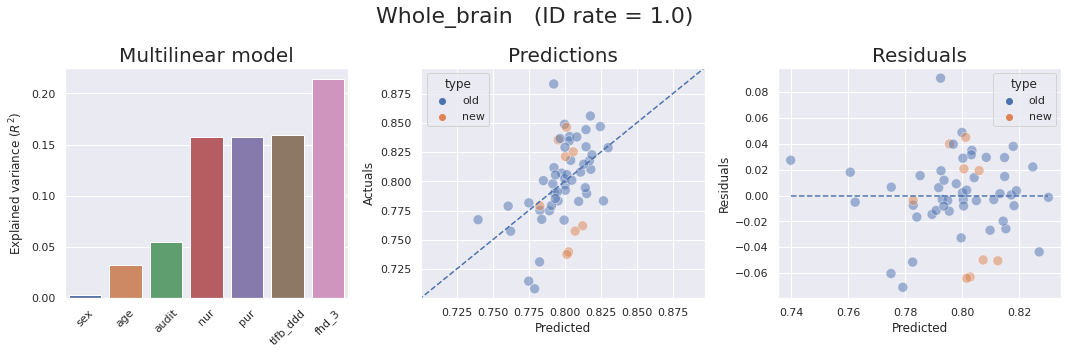

In [92]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'{network_info.network_name.values[0]}   (ID rate = {network_info.id_rate.values[0]})', fontsize=22)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.scatterplot(data=prediction_df, x="pred", y="actual", hue="type", alpha=0.5, s=100)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_ylim(p_center-n_std*p_std, p_center+n_std*p_std)
axes.set_xlim(p_center-n_std*p_std, p_center+n_std*p_std)
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.scatterplot(data=prediction_df, x="pred", y="error", hue="type", alpha=0.5, s=100)
axes.set_ylabel('Residuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

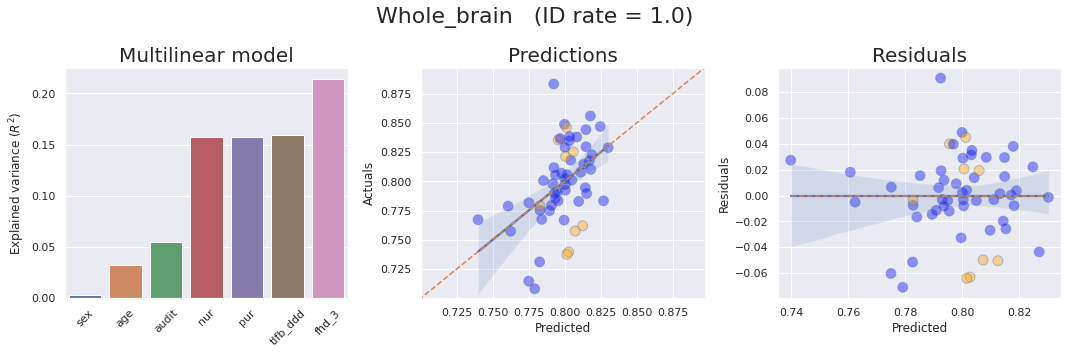

In [93]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'{network_info.network_name.values[0]}   (ID rate = {network_info.id_rate.values[0]})', fontsize=22)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.regplot(data=prediction_df, x="pred", y="actual", 
            scatter_kws={'facecolors':prediction_df['color'],'s':100, 'alpha':0.4})
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_ylim(p_center-n_std*p_std, p_center+n_std*p_std)
axes.set_xlim(p_center-n_std*p_std, p_center+n_std*p_std)
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.regplot(data=prediction_df, x="pred", y="error", 
            scatter_kws={'facecolors':prediction_df['color'],'s':100, 'alpha':0.4})
axes.set_ylabel('Residuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

### PLOT 1

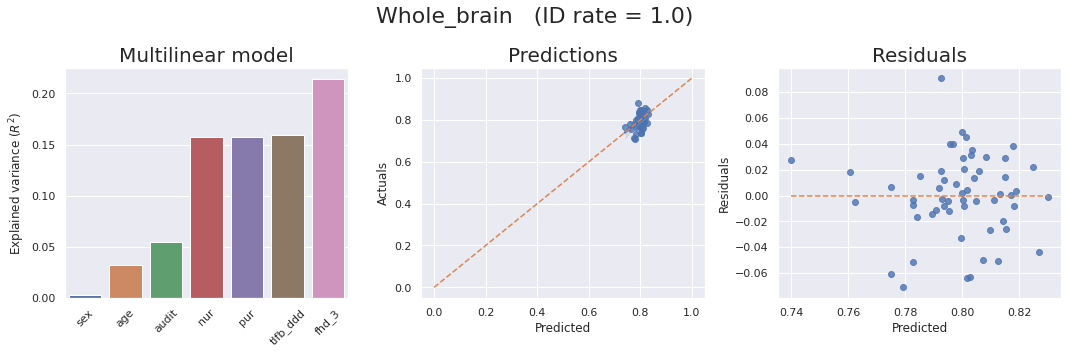

In [40]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'{network_info.network_name.values[0]}   (ID rate = {network_info.id_rate.values[0]})', fontsize=22)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.regplot(x=prediction.values, y=errors, fit_reg=False)
axes.set_ylabel('Residuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

### PLOT 2

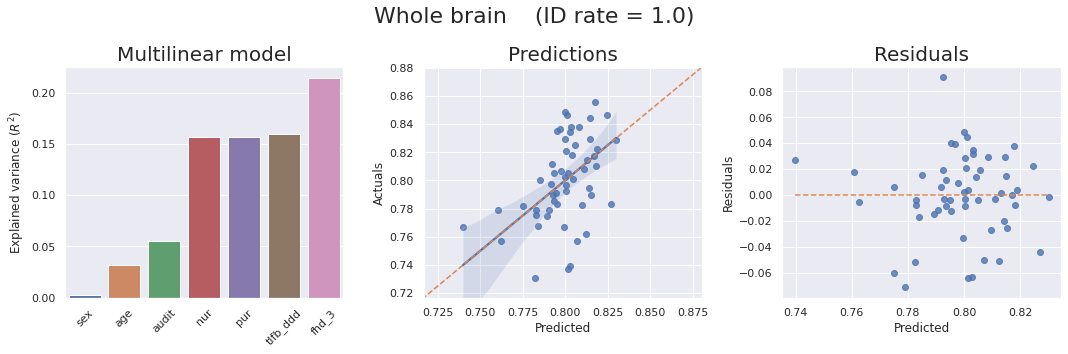

In [41]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'Whole brain    (ID rate = {network_info.id_rate.values[0]})', fontsize=22)
axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_ylim(p_center-5*p_std, p_center+5*p_std)
axes.set_xlim(p_center-5*p_std, p_center+5*p_std)
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.regplot(x=prediction.values, y=errors, fit_reg=False)
axes.set_ylabel('Residuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

#### CAT FHD BETA

In [225]:
network_r = {}
network_p = {}
for i in diagonals.columns:
    #print(i)
    X_raw, y_raw = demo_cfhd_beta.iloc[:,1:], diagonals[i] # CAT FHD BETA
    X_formula = pd.concat([X_raw, y_raw], axis=1)
    #print(X_formula.columns.values)
    variables = []
    r_values = []
    for j in X_formula.columns[:-1]:
        if j in ['sex','fhd_3']:
            j = 'C('+j+')'
        variables.append(j)
        formula = i+' ~ '+' + '.join(variables)
        #print(' ',formula)
        est = smf.ols(formula=formula, data=X_formula).fit()
        #print(' ',est.rsquared)
        r_values.append(est.rsquared)
        #print(' ',est.pvalues.round(3))
        
    #print('')
    network_r[i] = r_values
    network_p[i] = est.pvalues
print(formula)

prediction = est.predict(X_formula)

brain ~ C(sex) + age + C(fhd_3) + audit + nur + pur + tlfb_ddd


In [226]:
r_summary = pd.DataFrame(network_r, index=X_formula.columns.values[:-1])
p_summary = pd.DataFrame(network_p).round(4)

In [227]:
networks = pd.read_csv(netwoks_path)
networks['r2'] = r_summary.iloc[-1].values
networks['network_name'] = [x[14:] if len(x)>13 else x for x in networks['network_name']]
networks.sort_values('id_rate', ascending=False, inplace=True)
networks

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.000000,0.350756
10,n11,ContA_Temp_1,20,1.000000,0.248371
17,n18,aHIP-rh,32,1.000000,0.221340
14,n15,DefaultB_Temp_1,26,1.000000,0.092076
13,n14,DefaultA_IPL_1,16,1.000000,0.240724
11,n12,ContB_Temp_1,10,1.000000,0.144716
2,n3,SomMotA_1,16,0.979167,0.124167
3,n4,SomMotB_Aud_1,16,0.979167,0.197404
5,n6,DorsAttnB_PostC_1,10,0.979167,0.213489
0,n1,VisCent_ExStr_1,12,0.958333,0.238713


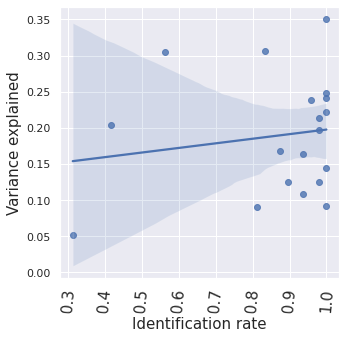

In [228]:
plt.figure(figsize=(5,5))
plt.title('', fontsize=20)
sns.regplot(x=networks.id_rate, y=networks.r2)
plt.ylabel('Variance explained', fontsize=15)
plt.xlabel('Identification rate', fontsize=15)
#plt.ylim(0,1.2)
plt.xticks(fontsize=15, rotation = 85)
#axes.set_title('Multilinear model',fontsize=20)
plt.show()

In [229]:
errors = diagonals[net] - prediction
network_info = networks[networks['network_id']==net]
network_info

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.0,0.350756


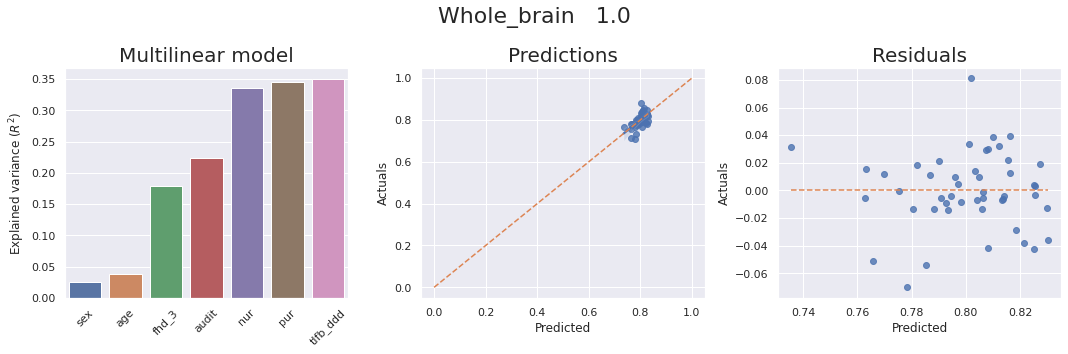

In [230]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'{network_info.network_name.values[0]}   {network_info.id_rate.values[0]}', fontsize=22)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.regplot(x=prediction.values, y=errors, fit_reg=False)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

### FHD NUMERIC MAP

In [231]:
network_r = {}
network_p = {}
for i in diagonals.columns:
    #print(i)
    X_raw, y_raw = demo_num_fhd.iloc[:,1:], diagonals[i] # CAT FHD
    X_formula = pd.concat([X_raw, y_raw], axis=1)
    #print(X_formula.columns.values)
    variables = []
    r_values = []
    for j in X_formula.columns[:-1]:
        if j in ['sex','cat_fhd']:
            j = 'C('+j+')'
        variables.append(j)
        formula = i+' ~ '+' + '.join(variables)
        #print(' ',formula)
        est = smf.ols(formula=formula, data=X_formula).fit()
        #print(' ',est.rsquared)
        r_values.append(est.rsquared)
        #print(' ',est.pvalues.round(3))
        
    #print('')
    network_r[i] = r_values
    network_p[i] = est.pvalues
print(formula)

prediction = est.predict(X_formula)

brain ~ C(sex) + age + audit + nur + pur + tlfb_ddd + fh


In [232]:
r_summary = pd.DataFrame(network_r, index=X_formula.columns.values[:-1])
p_summary = pd.DataFrame(network_p).round(4)

In [234]:
networks = pd.read_csv(netwoks_path)
networks['r2'] = r_summary.iloc[-1].values
networks['network_name'] = [x[14:] if len(x)>13 else x for x in networks['network_name']]
networks.sort_values('id_rate', ascending=False, inplace=True)
networks

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.000000,0.300241
10,n11,ContA_Temp_1,20,1.000000,0.248186
17,n18,aHIP-rh,32,1.000000,0.209234
14,n15,DefaultB_Temp_1,26,1.000000,0.092069
13,n14,DefaultA_IPL_1,16,1.000000,0.235892
11,n12,ContB_Temp_1,10,1.000000,0.138042
2,n3,SomMotA_1,16,0.979167,0.102265
3,n4,SomMotB_Aud_1,16,0.979167,0.122290
5,n6,DorsAttnB_PostC_1,10,0.979167,0.112449
0,n1,VisCent_ExStr_1,12,0.958333,0.231554


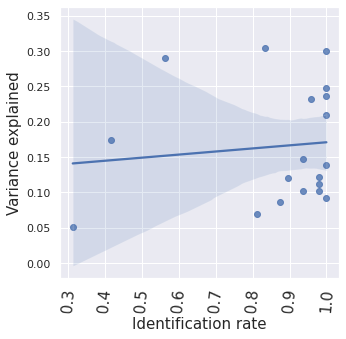

In [236]:
plt.figure(figsize=(5,5))
plt.title('', fontsize=20)
sns.regplot(x=networks.id_rate, y=networks.r2)
plt.ylabel('Variance explained', fontsize=15)
plt.xlabel('Identification rate', fontsize=15)
#plt.ylim(0,1.2)
plt.xticks(fontsize=15, rotation = 85)
#axes.set_title('Multilinear model',fontsize=20)
plt.show()

In [237]:
errors = diagonals[net] - prediction
network_info = networks[networks['network_id']==net]
network_info

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.0,0.300241


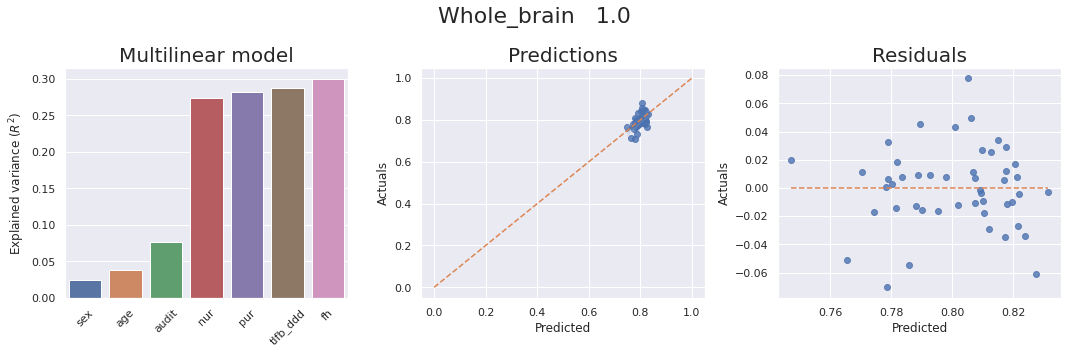

In [239]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'{network_info.network_name.values[0]}   {network_info.id_rate.values[0]}', fontsize=22)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.regplot(x=prediction.values, y=errors, fit_reg=False)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

### FHD MUMERIC MAP BETA

In [240]:
network_r = {}
network_p = {}
for i in diagonals.columns:
    #print(i)
    X_raw, y_raw = demo_num_fhd_beta.iloc[:,1:], diagonals[i] # CAT FHD
    X_formula = pd.concat([X_raw, y_raw], axis=1)
    #print(X_formula.columns.values)
    variables = []
    r_values = []
    for j in X_formula.columns[:-1]:
        if j in ['sex','cat_fhd']:
            j = 'C('+j+')'
        variables.append(j)
        formula = i+' ~ '+' + '.join(variables)
        #print(' ',formula)
        est = smf.ols(formula=formula, data=X_formula).fit()
        #print(' ',est.rsquared)
        r_values.append(est.rsquared)
        #print(' ',est.pvalues.round(3))
        
    #print('')
    network_r[i] = r_values
    network_p[i] = est.pvalues
print(formula)

prediction = est.predict(X_formula)

brain ~ C(sex) + age + fh + audit + nur + pur + tlfb_ddd


In [241]:
r_summary = pd.DataFrame(network_r, index=X_formula.columns.values[:-1])
p_summary = pd.DataFrame(network_p).round(4)

In [243]:
networks = pd.read_csv(netwoks_path)
networks['r2'] = r_summary.iloc[-1].values
networks['network_name'] = [x[14:] if len(x)>13 else x for x in networks['network_name']]
networks.sort_values('id_rate', ascending=False, inplace=True)
networks.round(2)

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.00,0.30
10,n11,ContA_Temp_1,20,1.00,0.25
17,n18,aHIP-rh,32,1.00,0.21
14,n15,DefaultB_Temp_1,26,1.00,0.09
13,n14,DefaultA_IPL_1,16,1.00,0.24
11,n12,ContB_Temp_1,10,1.00,0.14
2,n3,SomMotA_1,16,0.98,0.10
3,n4,SomMotB_Aud_1,16,0.98,0.12
5,n6,DorsAttnB_PostC_1,10,0.98,0.11
0,n1,VisCent_ExStr_1,12,0.96,0.23


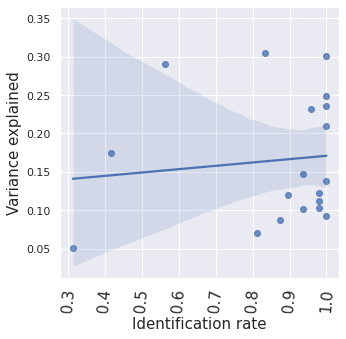

In [244]:
plt.figure(figsize=(5,5))
plt.title('', fontsize=20)
sns.regplot(x=networks.id_rate, y=networks.r2)
plt.ylabel('Variance explained', fontsize=15)
plt.xlabel('Identification rate', fontsize=15)
#plt.ylim(0,1.2)
plt.xticks(fontsize=15, rotation = 85)
#axes.set_title('Multilinear model',fontsize=20)
plt.show()

In [245]:
errors = diagonals[net] - prediction
network_info = networks[networks['network_id']==net]
network_info

,network_id,network_name,regions,id_rate,r2
18,brain,Whole_brain,232,1.0,0.300241


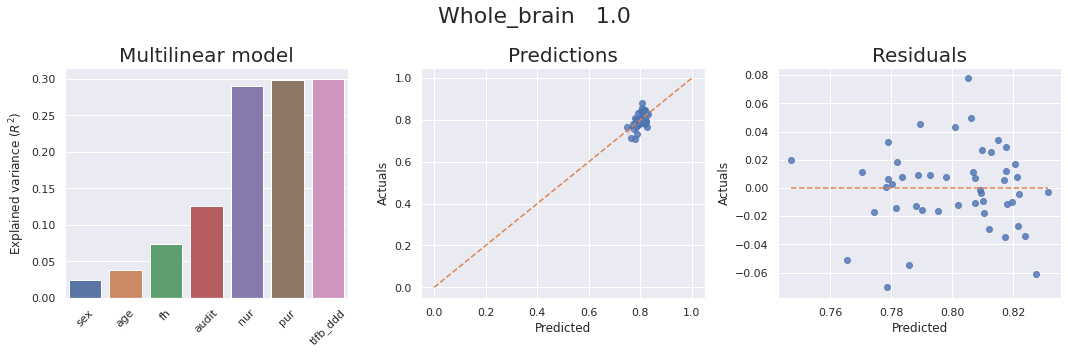

In [247]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(f'{network_info.network_name.values[0]}   {network_info.id_rate.values[0]}', fontsize=22)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(1, 3, 2)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(1, 3, 3)
sns.regplot(x=prediction.values, y=errors, fit_reg=False)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()

### Multiplot

In [70]:
minv = min(min(prediction), min(diagonals[net]))
maxv = max(max(prediction), max(diagonals[net]))
p_center, d_center = np.mean(prediction), np.mean(prediction)
p_std, d_std = np.std(prediction), np.std(prediction)
p_range, d_range = max(prediction)-min(prediction), max(diagonals[net])-min(diagonals[net])
p_range, d_range, minv, maxv

(0.08470463842009579,
 0.47388095273058084,
 0.5119689594523628,
 0.9858499121829436)

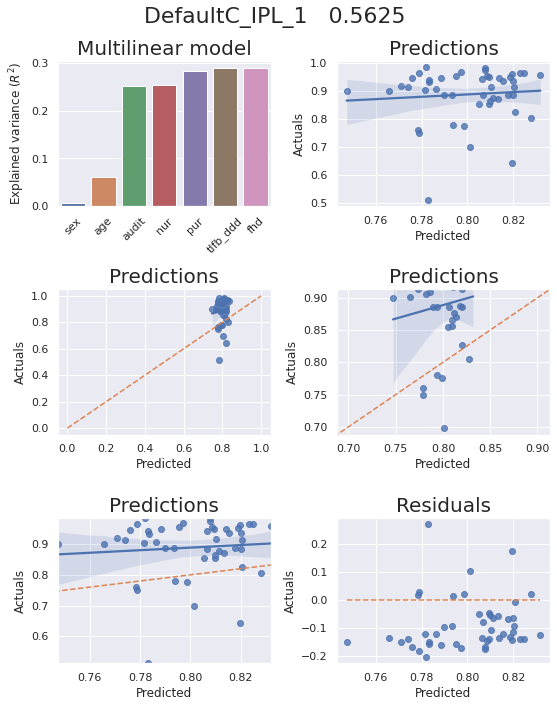

In [71]:
fig = plt.figure(figsize=(8,10))
fig.suptitle(f'{network_info.network_name.values[0]}   {network_info.idf_rate.values[0]}', fontsize=22)

axes = fig.add_subplot(3, 2, 1)
sns.barplot(data=r_summary, x=r_summary.index, y=net)
axes.set_ylabel('Explained variance ($R^2$)')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45)
axes.set_title('Multilinear model',fontsize=20)

axes = fig.add_subplot(3, 2, 2)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
#plt.plot([0,1],[0, 1], linestyle= "--")
#axes.set_ylim(p_center-6*p_std, p_center+6*p_std)
#axes.set_xlim(p_center-6*p_std, p_center+6*p_std)
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(3, 2, 3)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
#axes.set_ylim(p_center-6*p_std, p_center+6*p_std)
#axes.set_xlim(p_center-6*p_std, p_center+6*p_std)
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(3, 2, 4)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_ylim(p_center-6*p_std, p_center+6*p_std)
axes.set_xlim(p_center-6*p_std, p_center+6*p_std)
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(3, 2, 5)
sns.regplot(x=prediction, y=diagonals[net].values)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([0,1],[0, 1], linestyle= "--")
axes.set_ylim(min(diagonals[net]), max(diagonals[net]))
axes.set_xlim(min(prediction), max(prediction))
axes.set_title('Predictions',fontsize=20)

axes = fig.add_subplot(3, 2, 6)
sns.regplot(x=prediction.values, y=errors, fit_reg=False)
axes.set_ylabel('Actuals')
axes.set_xlabel('Predicted')
plt.plot([min(prediction),max(prediction)],[0, 0], linestyle= "--")
axes.set_title('Residuals',fontsize=20)

fig.tight_layout()
plt.show()